### Import modules

In [1]:
#### Import modules required
import multiprocessing as mp
import numpy as np
import os
import itertools
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sys
import datetime
from matplotlib import cm

os.chdir("C:/Users/gy17m2a/OneDrive - University of Leeds/Project/RAMP-UA/experiments/calibration")

# PYABC (https://pyabc.readthedocs.io/en/latest/)
import pyabc
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior
# Quieten down the pyopencl info messages (just print errors)
import logging

logging.getLogger("pyopencl").setLevel(logging.ERROR)

# Import arbitrary distribution class for using posterior estimates as new priors
sys.path.append('..')
from ArbitraryDistribution import ArbitraryDistribution

# RAMP model
from microsim.initialisation_cache import InitialisationCache
# from microsim.opencl.ramp.run import run_headless
# from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
# from microsim.opencl.ramp.snapshot import Snapshot
# from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
# from microsim.opencl.ramp.simulator import Simulator
# from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Bespoke RAMP classes for running the model
import sys

sys.path.append('..')
from opencl_runner import OpenCLWrapper  # Some additional functions to simplify running the OpenCL model
from opencl_runner import OpenCLRunner

# Set this to False to recalculate all results (good on HPC or whatever).
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True


C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


#### Read spatial data

In [2]:
# from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
# devon_msoa_codes =  pd.read_csv("observation_data/devon_msoa_codes.csv")

#### Create observed cases data
Can maybe move processing into other file and save outputs and just read into avoid confusion

In [9]:
# Observed cases data
cases_msoa_weekly = pd.read_csv("observation_data/weekly_cases_msoas_shifted_mpld_smoothed_IS.csv")
# remove date column
cases_msoa_weekly = cases_msoa_weekly.iloc[:, 1:]
# Transpose
cases_msoa_weekly = cases_msoa_weekly.T

# Observations are cases per msoa.
# Store as an array for us in model (more efficient?)
# (first axis is the msoa number, second is the day)
observations_weekly_array = cases_msoa_weekly.to_numpy()

## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon_shifted_mpld_smoothed_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()

# Read in daily devon case data (interpoalted from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()


#### Setup Model
Optionally initialise the population, delete the old OpenCL model snapshot (i.e. an already-initialised model) and
re-create a new one. Useful if something may have changed (e.g. changed the lockdown file).


In [4]:
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

DATA_DIR = os.path.join("..", "..", "devon_data")
cache_dir = os.path.join(DATA_DIR, "caches")
cache = InitialisationCache(cache_dir=cache_dir)
if cache.is_empty():
    raise Exception(f"The cache in {cache_dir} has not been initialised. Probably need to run the code a",
                    "few cells up that initialises the population")

individuals_df, activity_locations = cache.read_from_cache()

print(f"Activity locations: {activity_locations}")


Activity locations: {'Home': <Home ActivityLocation>, 'Retail': <Retail ActivityLocation>, 'PrimarySchool': <PrimarySchool ActivityLocation>, 'SecondarySchool': <SecondarySchool ActivityLocation>, 'Work': <Work ActivityLocation>}


#### Define constants
These are not touched by ABC. Include parameters that should not be optimised.

In [5]:
const_params_dict = {
    "current_risk_beta": 0.025239665550846085,  # Global risk multplier (leave this as it is and allow the other parameters to vary)
    "home": 1.0, # Risk associated with being at home. Again leave this constant so the coefficients of other places will vary around it
}

#### Define random variables and the prior distributions
Random variables are the global parameters.

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


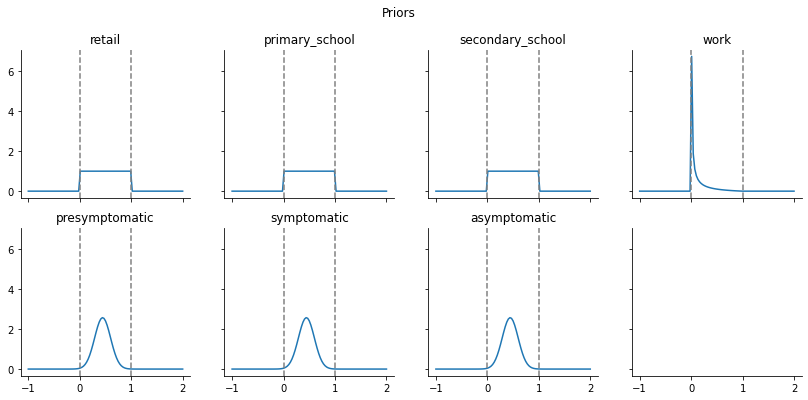

In [6]:
# School and retail multipliers are uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = (pyabc.RV("uniform", 0, 1) for _ in range(3))
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]  (see justification in abc)
# No idea about (pre)symptomatic, so use same distribution as asymptomatic
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = {
    "retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv
}

fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True)
x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, (var_name, variable) in enumerate(all_rv.items()):
    # var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    # ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=0.0, ls='--', color="grey", label="x=0")
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")

# ax.legend()
# fig.tight_layout()
fig.suptitle("Priors")
fig.show()

## Create a distrubtion from these random variables
decorated_rvs = {name: pyabc.LowerBoundDecorator(rv, 0.0) for name, rv in all_rv.items()}

# Define the original priors
original_priors = pyabc.Distribution(**decorated_rvs)

#### Setup loop for running model

In [7]:
# Path to parameters
parameters_file = os.path.join("../../", "model_parameters/",
                               "default.yml")  # Need to tell it where the default parameters are
# Set the size of a data assimilation window in days:
da_window_size = 7
# Dictionary with parameters for running model
admin_params = {"quiet": True, "use_gpu": True, "store_detailed_counts": True, "start_day": 0,
                "run_length": da_window_size,
                "current_particle_pop_df": None,
                "parameters_file": parameters_file, "snapshot_file": SNAPSHOT_FILEPATH, "opencl_dir": OPENCL_DIR,
                "individuals_df": individuals_df, "observations_weekly_array": observations_weekly_array,
                 'num_seed_days' :7}

# Create dictionaries to store the dfs, weights or history from each window (don't need all of these, but testing for now)
dfs_dict = {}
weights_dict = {}
history_dict = {}

# Store starting time to use to calculate how long processing the whole window has taken
starting_windows_time = datetime.datetime.now()

# Define number of windows to run for
windows = 2

# Loop through each window
for window_number in range(1, windows + 1):
    print("Window number: ", window_number)

    # Edit the da_window size in the admin params
    # print("Running for 14 days")
    admin_params['run_length'] = admin_params['run_length'] * window_number
    print("Running for {} days".format(da_window_size * window_number))

    # Create template for model
    template = OpenCLWrapper(const_params_dict, **admin_params)
    # Not sure why this is needed. Wthout it we get an error when passing the template object to ABCSMC below
    template.__name__ = OpenCLWrapper.__name__

    # Define priors
    # If first window, then use user-specified (original) priors
    if window_number == 1:
        # with open('abc-2_105days_7seeddays.pkl', 'rb') as f:
        #     old_history = pickle.load(f)
        # priors = ArbitraryDistribution(old_history)
        priors = original_priors
    # If a subsequent window, then generate distribution from posterior from previous window
    else:
        priors = ArbitraryDistribution(abc_history)

    # Set up model
    abc = pyabc.ABCSMC(
        models=template,  # Model (could be a list)
        parameter_priors=priors,  # Priors (could be a list)
        # summary_statistics=OpenCLWrapper.summary_stats,  # Summary statistics function (output passed to 'distance')
        distance_function=OpenCLWrapper.dummy_distance,  # Distance function
        sampler=pyabc.sampler.SingleCoreSampler()
        # Single core because the model is parallelised anyway (and easier to debug)
        # sampler=pyabc.sampler.MulticoreEvalParallelSampler()  # The default sampler
        # transition=transition,  # Define how to transition from one population to the next
    )

    # Prepare to run the model
    db_path = ("sqlite:///" + "ramp_da.db")  # Path to database

    # abc.new() needs the database location and any observations that we will use (these are passed to the
    # distance_function provided to pyabc.ABCSMC above). Currently the observations are provided to the model
    # when it is initialised and these are then used at the end of the model run() function. So they don't
    # need to be provided here.
    run_id = abc.new(
        db=db_path,
        observed_sum_stat=None  # {'observation': observations_array, "individuals": individuals_df}
    )

    # Run model
    abc_history = abc.run(max_nr_populations=2)

    # Save some info on the posterior parameter distributions.
    for t in range(0, abc.history.max_t + 1):
        print(t)
        # for this t (population) extract the 100 particle parameter values, and their weights
        df_t1, w_t1 = abc.history.get_distribution(m=0, t=t)
        # Are these equivalent? yes!
        # df_t1_2, w_t1_2 = abc_history.get_distribution(m=0, t=abc_history.max_t)
        # df_t1.equals(df_t1_2)
        # (w_t1 == w_t1_2).all()

        # Save these for use in plotting the prior on the plot of parameter values in each population
        dfs_dict["w{},pop{}".format(window_number, t)] = df_t1
        weights_dict["w{}, pop{}".format(window_number, t)] = w_t1
        history_dict["w{}".format(window_number)] = abc_history


Window number:  1
Running for 7 days


c:\users\gy17m2a\onedrive - university of leeds\project\ramp-ua\microsim\opencl\ramp\params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file. This warning will not be displayed again.
  warnings.warn("Params object is being created using hard-coded default values, "
ABC.History INFO: Start <ABCSMC id=38, start_time=2022-02-18 13:14:17>
ABC INFO: Calibration sample t = -1.


OpenclRunner ran model 1 in 0:00:02.514720
OpenclRunner ran model 2 in 0:00:01.744922
OpenclRunner ran model 3 in 0:00:01.723569
OpenclRunner ran model 4 in 0:00:01.686894
OpenclRunner ran model 5 in 0:00:01.786096
OpenclRunner ran model 6 in 0:00:01.780140
OpenclRunner ran model 7 in 0:00:01.752398
OpenclRunner ran model 8 in 0:00:01.686397
OpenclRunner ran model 9 in 0:00:01.572817
OpenclRunner ran model 10 in 0:00:01.538117
OpenclRunner ran model 11 in 0:00:01.637805
OpenclRunner ran model 12 in 0:00:01.724598
OpenclRunner ran model 13 in 0:00:01.664578
OpenclRunner ran model 14 in 0:00:01.687889
OpenclRunner ran model 15 in 0:00:01.688913
OpenclRunner ran model 16 in 0:00:01.674495
OpenclRunner ran model 17 in 0:00:01.613983
OpenclRunner ran model 18 in 0:00:01.739911
OpenclRunner ran model 19 in 0:00:01.613985
OpenclRunner ran model 20 in 0:00:01.523218
OpenclRunner ran model 21 in 0:00:01.556945
OpenclRunner ran model 22 in 0:00:01.676482
OpenclRunner ran model 23 in 0:00:01.6958

ABC INFO: t: 0, eps: 2.19014327e+03.


OpenclRunner ran model 101 in 0:00:01.649695
OpenclRunner ran model 102 in 0:00:01.669040
OpenclRunner ran model 103 in 0:00:01.719627
OpenclRunner ran model 104 in 0:00:01.640074
OpenclRunner ran model 105 in 0:00:01.782129
OpenclRunner ran model 106 in 0:00:01.885791
OpenclRunner ran model 107 in 0:00:01.975545
OpenclRunner ran model 108 in 0:00:01.672015
OpenclRunner ran model 109 in 0:00:01.906654
OpenclRunner ran model 110 in 0:00:01.766752
OpenclRunner ran model 111 in 0:00:01.713684
OpenclRunner ran model 112 in 0:00:01.809406
OpenclRunner ran model 113 in 0:00:01.631838
OpenclRunner ran model 114 in 0:00:01.626908
OpenclRunner ran model 115 in 0:00:01.815392
OpenclRunner ran model 116 in 0:00:01.687402
OpenclRunner ran model 117 in 0:00:01.721120
OpenclRunner ran model 118 in 0:00:01.780642
OpenclRunner ran model 119 in 0:00:01.719092
OpenclRunner ran model 120 in 0:00:02.100572
OpenclRunner ran model 121 in 0:00:01.735036
OpenclRunner ran model 122 in 0:00:01.597117
OpenclRunn

ABC INFO: Accepted: 100 / 100 = 1.0000e+00, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 2.19014327e+03.


OpenclRunner ran model 201 in 0:00:01.794988
OpenclRunner ran model 202 in 0:00:01.628367
OpenclRunner ran model 203 in 0:00:01.735500
OpenclRunner ran model 204 in 0:00:01.898192
OpenclRunner ran model 205 in 0:00:01.781132
OpenclRunner ran model 206 in 0:00:01.747282
OpenclRunner ran model 207 in 0:00:01.793009
OpenclRunner ran model 208 in 0:00:01.550001
OpenclRunner ran model 209 in 0:00:01.707229
OpenclRunner ran model 210 in 0:00:01.756716
OpenclRunner ran model 211 in 0:00:01.661103
OpenclRunner ran model 212 in 0:00:01.673993
OpenclRunner ran model 213 in 0:00:02.147183
OpenclRunner ran model 214 in 0:00:01.696815
OpenclRunner ran model 215 in 0:00:02.230015
OpenclRunner ran model 216 in 0:00:02.937310
OpenclRunner ran model 217 in 0:00:01.797006
OpenclRunner ran model 218 in 0:00:01.675485
OpenclRunner ran model 219 in 0:00:01.576255
OpenclRunner ran model 220 in 0:00:01.603604
OpenclRunner ran model 221 in 0:00:01.682926
OpenclRunner ran model 222 in 0:00:01.622419
OpenclRunn

ABC INFO: Accepted: 100 / 100 = 1.0000e+00, ESS: 8.1623e+00.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=38, duration=0:13:14.303252, end_time=2022-02-18 13:27:31>


0
1
Window number:  2
Running for 14 days


ABC.History INFO: Start <ABCSMC id=40, start_time=2022-02-18 13:27:32>
ABC INFO: Calibration sample t = -1.


OpenclRunner ran model 301 in 0:00:02.264230
OpenclRunner ran model 302 in 0:00:02.417997
OpenclRunner ran model 303 in 0:00:02.219101
OpenclRunner ran model 304 in 0:00:02.378318
OpenclRunner ran model 305 in 0:00:02.451233
OpenclRunner ran model 306 in 0:00:02.461683
OpenclRunner ran model 307 in 0:00:02.511248
OpenclRunner ran model 308 in 0:00:02.493389
OpenclRunner ran model 309 in 0:00:02.449039
OpenclRunner ran model 310 in 0:00:02.543983
OpenclRunner ran model 311 in 0:00:02.642684
OpenclRunner ran model 312 in 0:00:02.559356
OpenclRunner ran model 313 in 0:00:02.346572
OpenclRunner ran model 314 in 0:00:02.541018
OpenclRunner ran model 315 in 0:00:02.580189
OpenclRunner ran model 316 in 0:00:02.637301
OpenclRunner ran model 317 in 0:00:02.397662
OpenclRunner ran model 318 in 0:00:02.537041
OpenclRunner ran model 319 in 0:00:02.446801
OpenclRunner ran model 320 in 0:00:02.482477
OpenclRunner ran model 321 in 0:00:02.467101
OpenclRunner ran model 322 in 0:00:02.513228
OpenclRunn

ABC INFO: t: 0, eps: 8.92038382e+03.


OpenclRunner ran model 401 in 0:00:02.754485
OpenclRunner ran model 402 in 0:00:03.146122
OpenclRunner ran model 403 in 0:00:03.612383
OpenclRunner ran model 404 in 0:00:02.632763
OpenclRunner ran model 405 in 0:00:02.479501
OpenclRunner ran model 406 in 0:00:02.550929
OpenclRunner ran model 407 in 0:00:02.568290
OpenclRunner ran model 408 in 0:00:02.627323
OpenclRunner ran model 409 in 0:00:02.675930
OpenclRunner ran model 410 in 0:00:02.866388
OpenclRunner ran model 411 in 0:00:02.708653
OpenclRunner ran model 412 in 0:00:02.351570
OpenclRunner ran model 413 in 0:00:02.489419
OpenclRunner ran model 414 in 0:00:02.378317
OpenclRunner ran model 415 in 0:00:02.487436
OpenclRunner ran model 416 in 0:00:02.506746
OpenclRunner ran model 417 in 0:00:02.500557
OpenclRunner ran model 418 in 0:00:02.531085
OpenclRunner ran model 419 in 0:00:02.521695
OpenclRunner ran model 420 in 0:00:02.447787
OpenclRunner ran model 421 in 0:00:02.474045
OpenclRunner ran model 422 in 0:00:02.454883
OpenclRunn

ABC INFO: Accepted: 100 / 178 = 5.6180e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 7.52238382e+03.


OpenclRunner ran model 579 in 0:00:03.014186
OpenclRunner ran model 580 in 0:00:02.536020
OpenclRunner ran model 581 in 0:00:02.641197
OpenclRunner ran model 582 in 0:00:02.743794
OpenclRunner ran model 583 in 0:00:02.784541
OpenclRunner ran model 584 in 0:00:03.311290
OpenclRunner ran model 585 in 0:00:03.838487
OpenclRunner ran model 586 in 0:00:02.514636
OpenclRunner ran model 587 in 0:00:02.517197
OpenclRunner ran model 588 in 0:00:02.524141
OpenclRunner ran model 589 in 0:00:02.560845
OpenclRunner ran model 590 in 0:00:02.219387
OpenclRunner ran model 591 in 0:00:02.298462
OpenclRunner ran model 592 in 0:00:02.399646
OpenclRunner ran model 593 in 0:00:02.532574
OpenclRunner ran model 594 in 0:00:02.454205
OpenclRunner ran model 595 in 0:00:02.463134
OpenclRunner ran model 596 in 0:00:03.250283
OpenclRunner ran model 597 in 0:00:02.446268
OpenclRunner ran model 598 in 0:00:02.737421
OpenclRunner ran model 599 in 0:00:02.390707
OpenclRunner ran model 600 in 0:00:02.393729
OpenclRunn

OpenclRunner ran model 762 in 0:00:03.080194


ABC INFO: Accepted: 100 / 184 = 5.4348e-01, ESS: 7.5583e+00.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=40, duration=0:36:03.983646, end_time=2022-02-18 14:03:36>


0
1


In [11]:
fname = "mollytest_2windows_7seeddays_olddist_rubbishresults.pkl"
with open( fname, "wb" ) as f:
        pickle.dump( abc_history, f)

#### Get results at end of each window

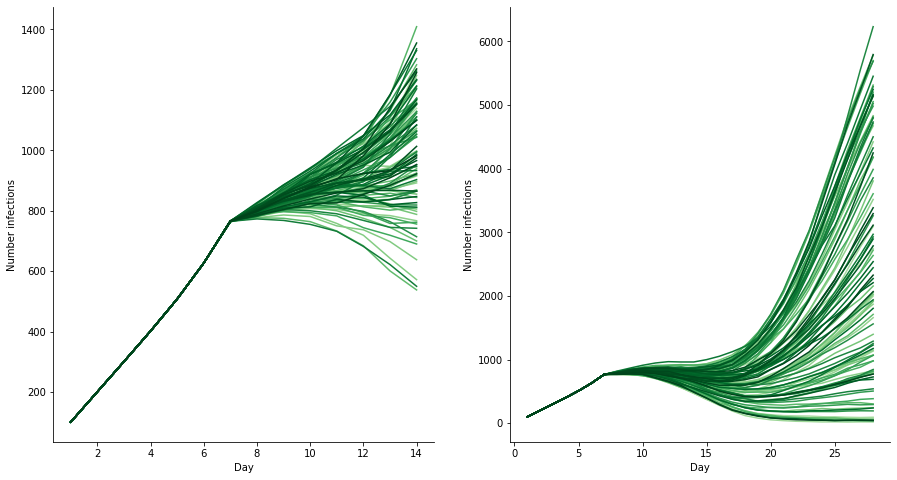

In [8]:
df = pd.DataFrame()
fig, axes = plt.subplots(1, 2, figsize=(15,8))
colors ={'w1': 'darkred', 'w2': 'darkblue'}
axes_number = 0
for window, n_days in { "w1": 14, "w2":28}.items():
    x=range(1,n_days+1)    
    history  = history_dict[window]   
    weighted_sum_stats_t0 = history.get_weighted_sum_stats_for_model(t=0)[1]
    
    evenly_spaced_interval = np.linspace(0.35, 1, 100)
    colors = [cm.Greens(x) for x in evenly_spaced_interval]
    for particle_no in range(0,100):
        particle_x_dict = weighted_sum_stats_t0[particle_no]
        cumulative_model_diseased_by_area = particle_x_dict["cumulative_model_diseased_by_area"]
        cumulative_model_diseased_by_area = cumulative_model_diseased_by_area.iloc[:,0:n_days]
        cumulative_model_diseased_by_area_devon_sum = cumulative_model_diseased_by_area.sum(axis=0)
    
        # Create dataframe to populate with results
        cumulative_model_diseased_by_area_weekly_sum = pd.DataFrame()
        # Define n weeks
        n_weeks = int(n_days / 7)
        # Loop through each week in n_weeks, find total number of cases in that week
        # for each MSOA, add column to dataframe containing this total
        for i in range(7, (n_weeks * 7) + 7, 7):
            weekly_total = cumulative_model_diseased_by_area.iloc[:, 0:i].sum(axis=1)
            #cumulative_model_diseased_by_area_weekly_sum["week{}Sum".format(int(i / 7))] = weekly_total
        # Sum over MSOAs
        cumulative_model_diseased_by_area_weekly_sum = cumulative_model_diseased_by_area_weekly_sum.sum(axis=0)
        df[particle_no] = cumulative_model_diseased_by_area_devon_sum
        
        axes[axes_number].plot(x,cumulative_model_diseased_by_area_devon_sum, color = colors[particle_no])
     
    
    axes[axes_number].plot(cases_devon_weekly['CumulativeCases']


    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_ylabel("Number infections")
    
    axes_number =axes_number +1

#### Plot the parameter values being used in each window
Doesn't work, unless rerun prior bit at top, not sure why

In [11]:
# #### Final population for each window
# evenly_spaced_interval = np.linspace(0.35, 1, 3)
# colors = [cm.Greens(x) for x in evenly_spaced_interval]

# fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
# for i, param in enumerate(original_priors.keys()):
#     color_i =0
#     ax = axes.flat[i]
#     # Add parameter priors
#     priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
#     ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": x}), 
#             color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
#     for history_name, history in history_dict.items():
#         color = colors[color_i]
#         df, w = history.get_distribution(m=0, t=history.max_t)
#         pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
#                 label=history_name, linewidth = 4,
#                 color= color)
#         ax.legend(fontsize="small")
#         ax.set_title(f"{param}")
#         handles, labels = ax.get_legend_handles_labels()
#         ax.get_legend().remove()
#         color_i = color_i +1
# fig.legend(handles, labels, loc='center right', fontsize = 17,
#             bbox_to_anchor=(1.01, 0.17))
#           # ncol = 8, bbox_to_anchor=(0.5, -0.07))
# axes[2,2].set_axis_off()
# axes[2,1].set_axis_off()
# fig.tight_layout()
# fig.show()
# # fig.savefig("Plots/8windows_14days_each_finalpop.jpg")

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


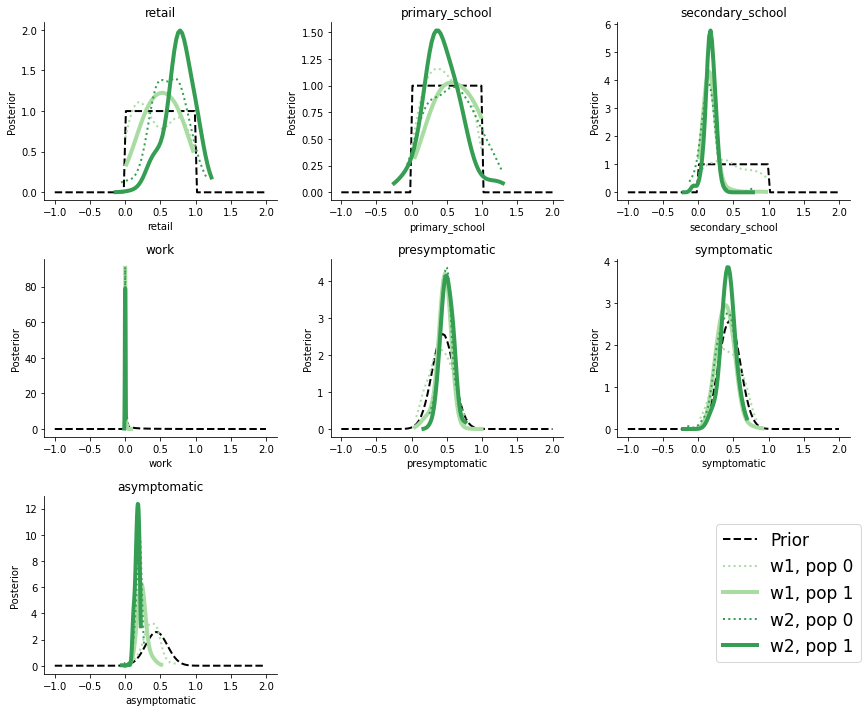

In [39]:
### Plot all populations for each window
evenly_spaced_interval = np.linspace(0.35, 1, 3)
colors = [cm.Greens(x) for x in evenly_spaced_interval]
linestyles = ['dotted','solid'] # check this is same length as n populations
linewidths = [2,4]
fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    for history_name, history in history_dict.items():
        color = colors[color_i]
        for t in range(history.max_t + 1):
            df, w = history.get_distribution(m=0, t=t)
            pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label="{}, pop {}".format(history_name, t),
                color = color,
                linestyle = linestyles[t],linewidth = linewidths[t])
            ax.legend(fontsize="small")
            #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
            ax.set_title(f"{param}")
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
        color_i = color_i +1
        
fig.legend(handles, labels, loc='center right', fontsize = 17,
            bbox_to_anchor=(1.01, 0.17))
          # ncol = 8, bbox_to_anchor=(0.5, -0.07))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()

#### Run the model X (50?) times using paramater values drawn from the posterior
Plot the results to compare the performance of the model with the observations

In [8]:
# Initialise the class so that its ready to run the model.
## Define parameters
PARAMETERS_FILE = os.path.join("../../", "model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

ITERATIONS = 105  # Number of iterations to run for
assert (ITERATIONS /7).is_integer()
NUM_SEED_DAYS = 7  # Number of days to seed the population
USE_GPU = True
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True
# assert ITERATIONS < len(OBSERVATIONS), \
# f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

OpenCLRunner.init(iterations=ITERATIONS,
                  repetitions=REPETITIONS,
                  observations=cases_devon_weekly,
                  use_gpu=USE_GPU,
                  use_healthier_pop=USE_HEALTHIER_POP,
                  store_detailed_counts=STORE_DETAILED_COUNTS,
                  parameters_file=PARAMETERS_FILE,
                  opencl_dir=OPENCL_DIR,
                  snapshot_filepath=SNAPSHOT_FILEPATH,
                  num_seed_days = NUM_SEED_DAYS)

# Set constants 
OpenCLRunner.set_constants(const_params_dict)

##### define the abc_history object (not necessary as this will be most recent abc_history anyway)
abc_history = history_dict['w2']

# Define the number of samples to take from the posterior distribution of parameters
N_samples = 30
df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)

# Sample from the dataframe of posteriors using KDE
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
samples = kde.rvs(N_samples)

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():
    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        # while (any(value < 0 for value in sample.values())):
        print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()
        # Added in this line as the sample was in the wrong format for the while loop
        sample = pd.Series(sample)

    # Create a dictionary with the parameters and their values for this sample
    #param_values = {param: sample[str(param)] for param in priors}
    param_values = sample.to_dict()
    print(param_values)
    # Run the model
    # _fitness = fitness (comparison between sim and obs)
    # _sim =  model_weekly_cumulative_infections
    # _obs = obs_weekly_cumulative_infections
    # _out_params = 
    # _summaries = 
    (_fitness, _sim, _obs, _out_params, _summaries) = \
        OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    print(f"Fitness: {_fitness}.")
    # print(f"Fitness: {_fitness}. Sample: {sample}")

    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")

# Sanity check - that observations in each case are the same length?
for i in range(len(obs_l) - 1):
    assert np.array_equal(obs_l[0], obs_l[i])

# Save these because it took ages to sample
def pickle_samples(mode, *arrays):
    if mode == "save":
        with open("abc-2-samples.pkl", "wb") as f:
            for x in arrays:
                pickle.dump(x, f)
        return
    elif mode == "load":
        with open("abc-2-samples.pkl", "rb") as f:
            fitness_l = pickle.load(f)
            sim_l = pickle.load(f)
            obs_l = pickle.load(f)
            out_params_l = pickle.load(f)
            out_calibrated_params_l = pickle.load(f)
            summaries_l = pickle.load(f)
        return (fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)
    else:
        raise Exception(f"Unkonwn mode: {mode}")

pickle_samples('save', fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)

# print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")

Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.2167654238870432, 'presymptomatic': 0.5287382373336411, 'primary_school': 0.62799929904676, 'retail': 0.6539104937224482, 'secondary_school': 1.0787838969028987, 'symptomatic': 0.3202415474126385, 'work': 0.03509672966766572}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:14<00:00, 14.87s/it]


Fitness: 13068.46354769376.
Found negatives. Resampling
{'asymptomatic': 0.026593069466138708, 'presymptomatic': 0.3516172819419809, 'primary_school': 0.4932113124902727, 'retail': 0.46392127142617673, 'secondary_school': 0.8829251016529347, 'symptomatic': 0.3725024983194277, 'work': 0.10773480992013992}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:12<00:00, 14.56s/it]


Fitness: 42557.174074130075.
{'asymptomatic': 0.17622016332380294, 'presymptomatic': 0.7502806099852132, 'primary_school': 0.5015094250327504, 'retail': 0.7860510129540161, 'secondary_school': 1.2060462966489853, 'symptomatic': 0.270720987591897, 'work': 0.11690701702771493}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:14<00:00, 14.92s/it]


Fitness: 16617.977136994054.
{'asymptomatic': 0.22728049981873627, 'presymptomatic': 0.89873466623717, 'primary_school': 0.4665231640038072, 'retail': 1.1503378763111292, 'secondary_school': 0.9359061103152505, 'symptomatic': 0.24843307952907898, 'work': 0.023043432652274893}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:15<00:00, 15.07s/it]


Fitness: 22453.212413205292.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.19315392602580067, 'presymptomatic': 0.6352259994553567, 'primary_school': 0.8839456882692772, 'retail': 0.29184605281989073, 'secondary_school': 0.46083699593700295, 'symptomatic': 0.6134986222528873, 'work': 0.061860327631540826}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:13<00:00, 14.78s/it]


Fitness: 13452.072571758652.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.20623439267435628, 'presymptomatic': 0.49647351959294167, 'primary_school': 0.19799354171013692, 'retail': 0.7028528269641408, 'secondary_school': 0.47729872255518374, 'symptomatic': 0.5075277907784022, 'work': 0.0485542992268644}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:15<00:00, 15.11s/it]


Fitness: 15196.824358530885.
Found negatives. Resampling
{'asymptomatic': 0.4139049734541172, 'presymptomatic': 0.4995051894242078, 'primary_school': 0.46647759025943347, 'retail': 0.6151761616178236, 'secondary_school': 0.06460825173772768, 'symptomatic': 0.3968070063098726, 'work': 0.0013898367978068486}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:18<00:00, 15.66s/it]


Fitness: 11895.38756231866.
{'asymptomatic': 0.2024955235962025, 'presymptomatic': 0.6201836188040858, 'primary_school': 0.9270269647739, 'retail': 0.7346576037079173, 'secondary_school': 1.3550134535719365, 'symptomatic': 0.35558739175777465, 'work': 0.018091198377321895}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:15<00:00, 15.07s/it]


Fitness: 24542.27280024303.
{'asymptomatic': 0.09411352194264254, 'presymptomatic': 0.5018749107717643, 'primary_school': 1.2024572564095326, 'retail': 0.406159100277463, 'secondary_school': 0.028494943598031813, 'symptomatic': 0.4274955266786114, 'work': 0.14602190554251637}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:13<00:00, 14.67s/it]


Fitness: 34955.18073787081.
{'asymptomatic': 0.16675520306322994, 'presymptomatic': 0.8877293687034342, 'primary_school': 0.5684919570707386, 'retail': 1.3420272828784923, 'secondary_school': 1.2983691353141165, 'symptomatic': 0.11696981164401499, 'work': 0.023571385483895355}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:14<00:00, 14.81s/it]


Fitness: 16933.982084883322.
{'asymptomatic': 0.238981020521533, 'presymptomatic': 0.4605043477235803, 'primary_school': 0.1780897429824853, 'retail': 0.2429597933973458, 'secondary_school': 0.3707102149490302, 'symptomatic': 0.4750166880904314, 'work': 0.12087787214327603}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:14<00:00, 14.86s/it]


Fitness: 6079.243558236398.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.31920904882911566, 'presymptomatic': 0.5502960335931436, 'primary_school': 0.18404488496961816, 'retail': 0.5237353221909774, 'secondary_school': 0.4744294727176376, 'symptomatic': 0.36636101817912725, 'work': 0.026499436809568774}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:16<00:00, 15.30s/it]


Fitness: 8447.455418337991.
{'asymptomatic': 0.2434193112546294, 'presymptomatic': 0.42222476835685085, 'primary_school': 0.5877629726652117, 'retail': 0.46651844354959704, 'secondary_school': 0.8456529518568301, 'symptomatic': 0.4832669013181772, 'work': 0.027756843143140048}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:15<00:00, 15.08s/it]


Fitness: 7802.969709137928.
Found negatives. Resampling
{'asymptomatic': 0.1066779654839326, 'presymptomatic': 0.7088706726471516, 'primary_school': 0.48174502031854055, 'retail': 0.6577454577525208, 'secondary_school': 1.2211672564637581, 'symptomatic': 0.1922029284524362, 'work': 0.11171922873098064}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:15<00:00, 15.13s/it]


Fitness: 23310.9289431705.
Found negatives. Resampling
{'asymptomatic': 0.16349532299412872, 'presymptomatic': 0.6292445756503325, 'primary_school': 0.4711418806840354, 'retail': 1.0054401721228812, 'secondary_school': 0.9623300157289578, 'symptomatic': 0.3088883402769389, 'work': 0.02797602816297368}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:14<00:00, 14.97s/it]


Fitness: 10195.101570927873.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.28844808380653925, 'presymptomatic': 0.7211236154878895, 'primary_school': 0.6912768445308387, 'retail': 1.0641280267625404, 'secondary_school': 1.0692357056294088, 'symptomatic': 0.1613724636523941, 'work': 0.0651033281970854}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.52s/it]


Fitness: 44539.41110224788.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.24342759564676966, 'presymptomatic': 0.7988383855041086, 'primary_school': 0.3951739968785687, 'retail': 1.1640218042153285, 'secondary_school': 0.9671154299665347, 'symptomatic': 0.18971172598914576, 'work': 0.003198296703780943}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.62s/it]


Fitness: 24167.63207812264.
{'asymptomatic': 0.3804040614291256, 'presymptomatic': 0.3732543530564072, 'primary_school': 0.8049261252959501, 'retail': 0.5628682909530616, 'secondary_school': 0.20257510855504157, 'symptomatic': 0.2110792883965028, 'work': 0.057420504855304144}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.64s/it]


Fitness: 10774.11996591834.
{'asymptomatic': 0.2998180341835779, 'presymptomatic': 0.3355968248461248, 'primary_school': 0.3208209848406997, 'retail': 0.7184521329171241, 'secondary_school': 0.42528204151937143, 'symptomatic': 0.354559479024171, 'work': 0.04016674914772051}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.71s/it]


Fitness: 5721.994824659717.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.18060534980658444, 'presymptomatic': 0.7044321114912315, 'primary_school': 1.0835965564175705, 'retail': 0.8467224941708399, 'secondary_school': 0.5087535241758359, 'symptomatic': 0.12319197924451984, 'work': 0.12842084562286277}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.75s/it]


Fitness: 10028.3825449687.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.3414503849317091, 'presymptomatic': 0.7429517678998331, 'primary_school': 0.22221312045334832, 'retail': 0.7417659689155868, 'secondary_school': 0.23636936287802368, 'symptomatic': 0.31566476952906714, 'work': 0.08444895441366129}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.82s/it]


Fitness: 15657.164706336516.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.13335783121653186, 'presymptomatic': 0.30758872241935675, 'primary_school': 0.29354031250312046, 'retail': 0.4304696092671668, 'secondary_school': 0.538665295070881, 'symptomatic': 0.6193626256358808, 'work': 0.08221692823383525}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.35s/it]


Fitness: 32010.035443733334.
{'asymptomatic': 0.3699135386480198, 'presymptomatic': 0.17055334266360878, 'primary_school': 0.6134048236122083, 'retail': 0.5070478710122563, 'secondary_school': 0.8862505310037215, 'symptomatic': 0.4460500563439812, 'work': 0.06989712409864271}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.73s/it]


Fitness: 41707.05753974463.
{'asymptomatic': 0.11318375262405878, 'presymptomatic': 0.710574643066342, 'primary_school': 0.5670417347694313, 'retail': 0.8341293616605922, 'secondary_school': 0.8569279535185458, 'symptomatic': 0.2614396027984494, 'work': 0.02531383371439338}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.62s/it]


Fitness: 28355.027595011117.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.1591244028619353, 'presymptomatic': 0.4837658419740797, 'primary_school': 0.5572928073911265, 'retail': 0.8079056646092637, 'secondary_school': 0.8444499270406511, 'symptomatic': 0.4758429896247907, 'work': 0.03472984545382614}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:51<00:00, 10.23s/it]


Fitness: 18971.86300710623.
{'asymptomatic': 0.24832769003240912, 'presymptomatic': 0.4009756825781469, 'primary_school': 0.9711197841957342, 'retail': 0.431954722333193, 'secondary_school': 0.7200150975996473, 'symptomatic': 0.499105711671606, 'work': 0.1418068345644504}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.45s/it]


Fitness: 16373.214763129306.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.07902147159931086, 'presymptomatic': 0.7640679098527806, 'primary_school': 0.7245513902655384, 'retail': 1.2781773032833104, 'secondary_school': 1.2472235864132295, 'symptomatic': 0.20206265399522716, 'work': 0.1276821936375364}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.99s/it]


Fitness: 28128.91374294388.
{'asymptomatic': 0.33181469031631494, 'presymptomatic': 0.5425930379704114, 'primary_school': 0.8473664494625488, 'retail': 1.0098866751374724, 'secondary_school': 1.0513564261495703, 'symptomatic': 0.38990371118065925, 'work': 0.0115848124400457}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.84s/it]


Fitness: 53223.449235233915.
{'asymptomatic': 0.10487921887179086, 'presymptomatic': 0.8064277275208813, 'primary_school': 0.7357360118472399, 'retail': 1.124634791829141, 'secondary_school': 1.2128085772059678, 'symptomatic': 0.23398662885309995, 'work': 0.04644652521467297}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.69s/it]


Fitness: 20832.118692541742.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.1783462494342876, 'presymptomatic': 0.37176707647633295, 'primary_school': 0.9340982521816082, 'retail': 1.047110030334452, 'secondary_school': 0.9587743223031508, 'symptomatic': 0.40262912613335844, 'work': 0.07581514929091085}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.71s/it]

Fitness: 11942.356876023421.
Finished sampling. Ignored 54 negative samples.


#### Plot the individual results for each sample

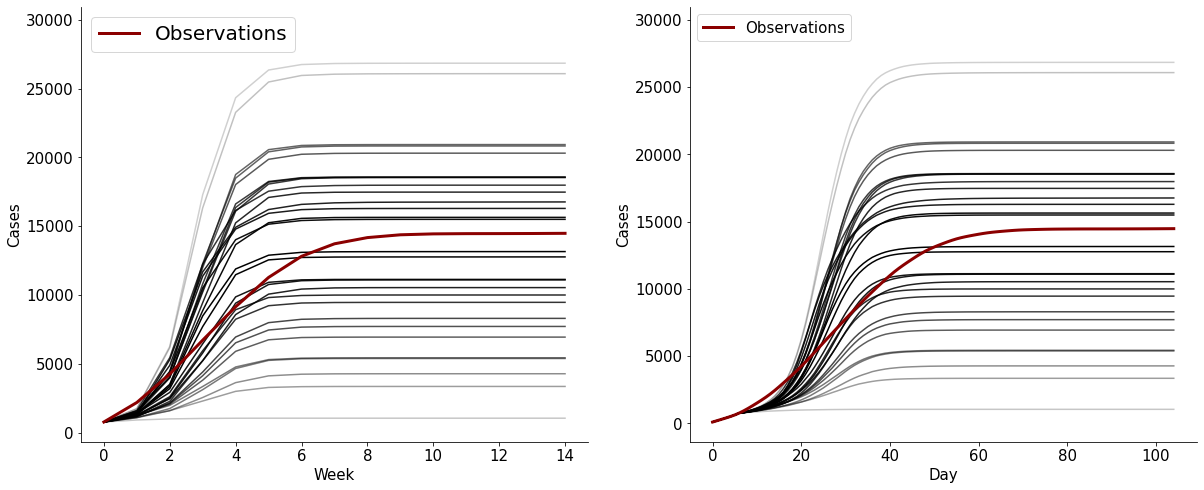

In [10]:
# Read in initial cases data (ued in seeding)
initial_cases = pd.read_csv("../../microsim/opencl/data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
initial_cases['CumulativeCases'] = initial_cases['num_cases'].cumsum()
initial_cases_weekly = pd.DataFrame({'OriginalCases':
                                    initial_cases['num_cases'].groupby(initial_cases['num_cases'].index // 7).sum()})
initial_cases_weekly['CumulativeCases'] = initial_cases_weekly.cumsum()

# Normalise fitness to 0-1 to calculate transparency
_fitness = np.array(fitness_l)  # Easier to do maths on np.array
fitness_norm = (_fitness - min(_fitness)) / (max(_fitness) - min(_fitness))

############## PLOT WEEKLY DATA
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax1.plot(x, sim_l[i],
            color="black", alpha=1 - fitness_norm[i]) # (1-x because high fitness is bad)
# Plot observations
ax1.plot(x, initial_cases_weekly['CumulativeCases'][0:int((105/7))], label="Observations", linewidth=3, color="darkred")
# Plot result from manually calibrated model
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel("Week", size=15)
ax1.set_ylabel("Cases",size=15)

############## PLOT DAILY DATA
x = range(len(OpenCLRunner.get_cumulative_new_infections(summaries_l[1])))
for i in range(len(summaries_l)):
    ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            # label=f"Particle {df.index[sample_idx[i]]}",
            color="black", alpha=1 - fitness_norm[i]  # (1-x because high fitness is bad)
            )
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"Fitness {round(fitness_l[i])}", fontsize=8)
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"P{df.index[sample_idx[i]]}, F{round(fitness_l[i])}", fontsize=8)
# Plot observations
ax2.plot(x, initial_cases['CumulativeCases'][0:105], label="Observations", linewidth = 3, color="darkred")
# Plot result from manually calibrated model
# ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# Format
ax2.legend(fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel("Day", size=15)
ax2.set_ylabel("Cases",size=15)

del _fitness, fitness_norm


### Save/pickle

In [41]:
fname = "2windows_7seeds_OldDistance_abc.pkl"
with open( fname, "wb" ) as f:
        pickle.dump( history, f)